# Probabilistic Reconciliation via Conditioning with bayesreconpy

# Introduction

This notebook shows how to perform *probabilistic reconciliation* with the `bayesreconpy` package. It is the python version of the original vignette in R available [here](https://cran.r-project.org/web/packages/bayesRecon/vignettes/bayesRecon.html). We provide three examples:

1. *Temporal hierarchy for a count time series*: we build a temporal hierarchy over a count time series, import the base forecasts from R that used `glarma` and reconcile them via Bottom-Up Importance Sampling (BUIS).
2. *Temporal hierarchy for a smooth time series*: we build a temporal hierarchy over a smooth time series, import the base forecasts from R that used `ets` and we reconcile them in closed form using Gaussian reconciliation. The covariance matrix is diagonal.
3. *Hierarchical of smooth time series*: this is an example of a cross-sectional hierarchy. We obtain the base forecasts from R that used `ets` and we reconcile them via Gaussian reconciliation. The covariance matrix is full and estimated via shrinkage.

Note: We import the base forecasts instead of generating them to check the similarity in results in both; different packages in python and R might lead different base forecasts even with the same method, and we avoid it here since obtaining base forecast is not the main objective here.

# Installation

The package, available at [pip](https://pypi.org/project/bayesreconpy/), can be installed and loaded with the usual commands:
`pip install bayesreconpy`

Loading the package:

In [13]:
import bayesreconpy

We select a monthly time series of counts from the *carparts* dataset, available from the expsmooth package (R. J. Hyndman 2015). The data set contains time series of sales of cars part from Jan. 1998 to Mar. 2002. For this example we select time series #2655, which is available as `carparts_example.pkl`.

This time series has a skewed distribution of values.

In [14]:
%pip install matplotlib
%pip install tabulate

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from properscoring import crps_ensemble
from bayesreconpy.hierarchy import _get_reconc_matrices, _temporal_aggregation
from bayesreconpy.reconc_BUIS import reconc_BUIS
from bayesreconpy.reconc_gaussian import reconc_gaussian
from scipy.stats import norm
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


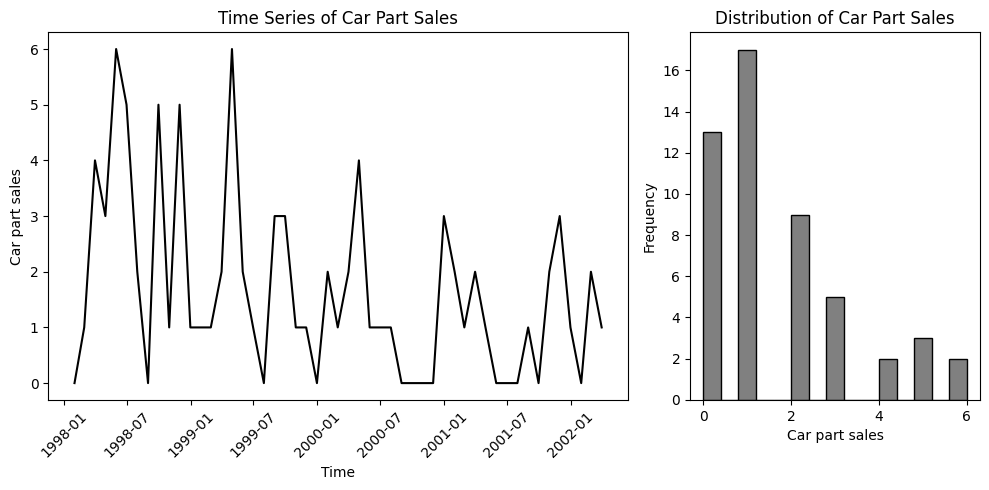

In [3]:
# Sample data (replace with your actual data)
carparts_example = pd.read_pickle('../data/carparts_example.pkl')

flat_data = carparts_example.values.flatten()
flat_data = flat_data[~np.isnan(flat_data)]  # Remove NaN values for plotting

# Generate a date range for the x-axis labels
# Start from "1998-01", with monthly frequency, matching the length of the data
date_index = pd.date_range(start="1998-01", periods=len(flat_data), freq="M")

# Create the layout: 1 row, 2 columns with custom widths
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

# Time series plot in the first subplot with timestamps on x-axis
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(date_index, flat_data, color='black')  # Single line plot with timestamps
ax1.set_xlabel("Time")
ax1.set_ylabel("Car part sales")
ax1.set_title("Time Series of Car Part Sales")
ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

# Histogram in the second subplot
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(flat_data, bins=15, color='gray', edgecolor='black')
ax2.set_xlabel("Car part sales")
ax2.set_ylabel("Frequency")
ax2.set_title("Distribution of Car Part Sales")

plt.tight_layout()
plt.show()


We divide the time series into train and test; the test set contains the last 12 months.

In [4]:
carparts_example = carparts_example.stack()  # Convert to long format
carparts_example.index = pd.to_datetime(
    [f"{year}-{month}" for year, month in carparts_example.index], format="%Y-%b"
)

# Now split into train and test sets
train = carparts_example[:'2001-03']
test = carparts_example['2001-04':]

We build the temporal hierarchy using the temporal aggregation function. We specify the aggregation levels using the agg_levels argument; in this case they are 2-Monthly, Quarterly, 4-Monthly, Biannual, and Annual.

In [5]:
agg_levels = {
    "Annual": train.resample("A").sum(),      # Annual aggregation
    "Biannual": train.resample("6M").sum(),   # Biannual aggregation (every 6 months)
    "4-Monthly": train.resample("4M").sum(),  # Every 4 months
    "Quarterly": train.resample("Q").sum(),   # Quarterly aggregation
    "2-Monthly": train.resample("2M").sum(),  # Bi-monthly (every 2 months)
    "Monthly": train.resample("M").sum()      # Monthly aggregation
}

The function returns a list of aggregated time series, ordered from the most aggregated (top of the hierarchy) to the most disagreggated (bottom of the hierarchy). We plot them below.

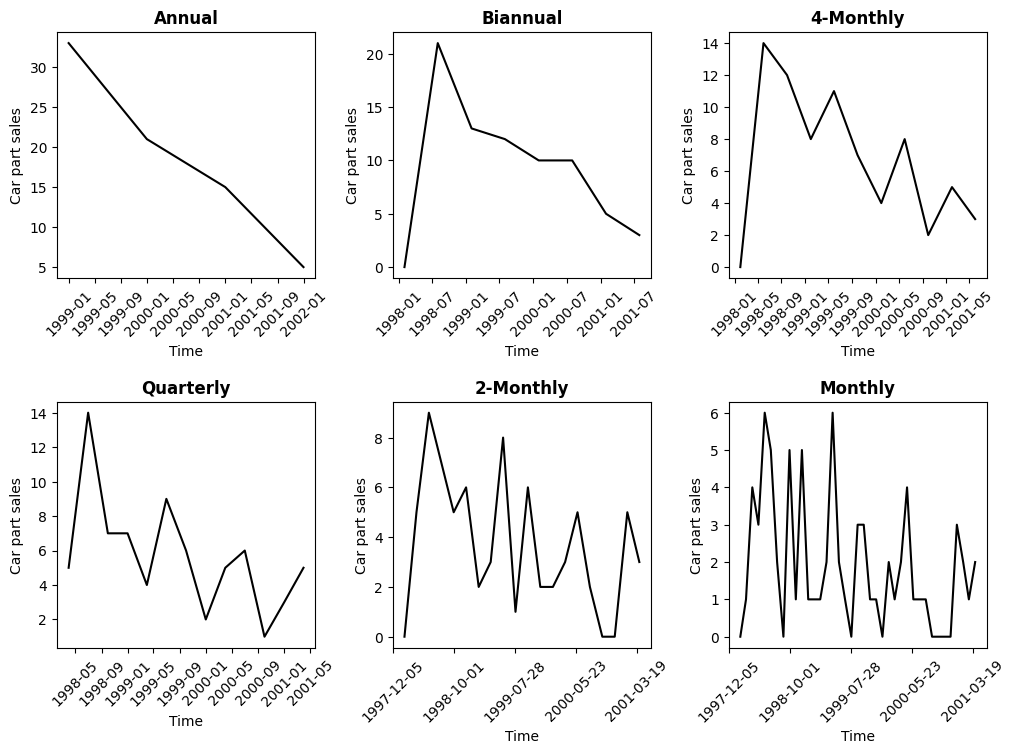

In [6]:
# Define the layout for the plots with adjusted spacing
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows, 3 columns
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between plots

# Plot each aggregated time series in its own subplot
for ax, (level, data) in zip(axes.flatten(), agg_levels.items()):
    ax.plot(data, color='black')  # Change line color to black for consistency
    ax.set_xlabel("Time")
    ax.set_ylabel("Car part sales")
    ax.set_title(level, fontsize=12, fontweight='bold')  # Increase title font size and weight
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

    # Reduce the number of x-axis ticks for readability, if there are too many
    if level in ["Monthly", "2-Monthly"]:
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Adjust number of ticks for readability

plt.show()

We import the base forecasts from `fc_samples.pkl` as fc_samples which were obtained in R using `glarma` .

In [7]:
fc_samples = pd.read_pickle('../data/fc_samples.pkl')

Reconciliation requires the aggregation matrix `A`, which we obtain using the function `get_reconc_matrices`. It requires:

- the aggregation factors of the hierarchy, which in this example are ;
    
    {2,3,4,6,12}
    
- the length of the forecasting horizon at the bottom level, which is 12 in this example.

In [8]:
agg_levels = [2, 3, 4, 6, 12]
h = 12
recon_matrices = _get_reconc_matrices(agg_levels, h)

# Aggregation matrix A
A = recon_matrices['A']


To reconcile using Bottom-Up Important Sampling (BUIS) we we use the function `reconc_BUIS`, passing to it the `A` matrix, the `*base forecasts*`, the type of the base forecasts (`in_type=“samples”`) and whether the samples are discrete or integer (`distr= “discrete”`).

In [9]:
np.random.seed(42)
recon_res = reconc_BUIS(A, fc_samples, in_type="samples", distr="discrete", seed=42)

Here we obtain samples from the reconciled forecast distribution.

In [10]:
print("Dimensions of reconciled_samples:", recon_res['reconciled_samples'].shape)

Dimensions of reconciled_samples: (28, 20000)


We now compute the Mean Absolute Error (MAE) and the Continuous Ranked Probability Score (CRPS) for the bottom (i.e., *monthly*) time series. For computing CRPS, we use our own function.

In [12]:
import numpy as np
import pandas as pd

def compute_crps(y_true, ensemble_preds, q_min=None):
    """
    Compute CRPS between truth and ensemble forecasts.

    Args:
        y_true: np.ndarray of shape (n,)
        ensemble_preds: np.ndarray of shape (n, m) — m ensemble samples per n forecast points
        q_min: float or None — optionally exclude lower quantiles

    Returns:
        crps: np.ndarray of shape (n,)
    """
    if y_true.ndim == 1:
        y_true = y_true[:, None]
    if q_min is not None:
        start = int(ensemble_preds.shape[1] * q_min)
        y_hat_sorted = np.sort(ensemble_preds[:, start:], axis=1)
    else:
        y_hat_sorted = np.sort(ensemble_preds, axis=1)

    m = y_hat_sorted.shape[1]
    ranks = np.arange(1, m + 1)

    return (2 / m) * np.nanmean((y_hat_sorted - y_true) *
                                (m * (y_true < y_hat_sorted) - ranks + 0.5), axis=1)

# --- Evaluate base and reconciled forecasts ---

# Create arrays to store absolute errors
ae_fc = []
ae_reconc = []

# Convert test set to array
test_array = test.to_numpy()

# Construct forecast sample arrays
base_ens = np.stack([fc_samples[len(A) + h] for h in range(len(test))])  # shape (H, S)
reconc_ens = recon_res['bottom_reconciled_samples']  # shape (H, S)

# Compute medians for point prediction error (MAE)
y_hat_medians = np.median(base_ens, axis=1)
y_reconc_medians = np.median(reconc_ens, axis=1)

ae_fc = np.abs(test_array - y_hat_medians)
ae_reconc = np.abs(test_array - y_reconc_medians)

# Compute CRPS using the custom function
crps_fc = compute_crps(test_array, base_ens)
crps_reconc = compute_crps(test_array, reconc_ens)

# Aggregate metrics
mae_fc = np.mean(ae_fc)
mae_reconc = np.mean(ae_reconc)
crps_fc_mean = np.mean(crps_fc)
crps_reconc_mean = np.mean(crps_reconc)

# Format results as DataFrame
metrics = pd.DataFrame({
    "base.forecasts": [mae_fc, crps_fc_mean],
    "reconciled.forecasts": [mae_reconc, crps_reconc_mean]
}, index=["MAE", "CRPS"])

print(metrics)


      base.forecasts  reconciled.forecasts
MAE         1.250000               1.00000
CRPS        0.708009               0.64111


The results match with R, with a negligible difference in CRPS possibly due to the usage of different implementations of the CRPS function.

# Temporal hierarchy over a smooth time series

In this second example, we select a smooth monthly time series (N1485) from the M3 forecasting competition (Makridakis and Hibon 2000). The data set is available in the Mcomp package (R. Hyndman 2018) and this time series is available as `M3_example.pkl`.

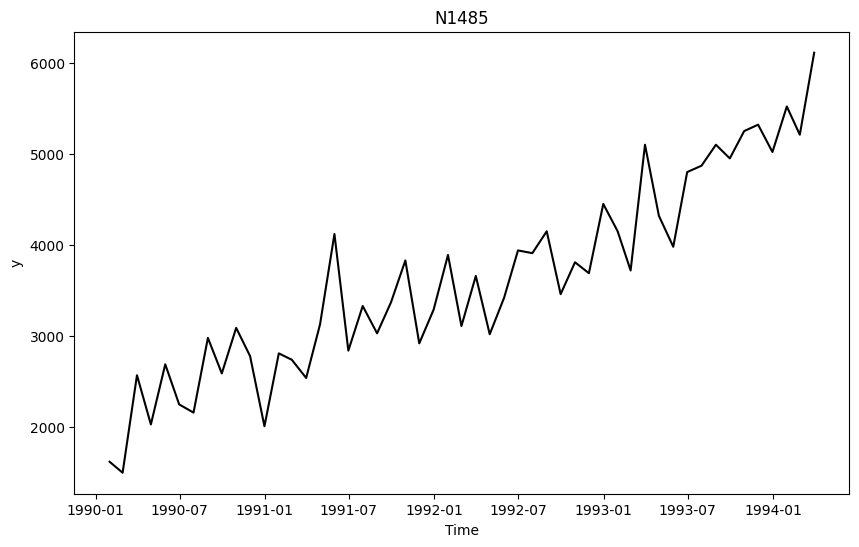

In [35]:
M3_example = pd.read_pickle('../data/M3_example.pkl')
train_data = M3_example['train'].stack()

date_index = pd.date_range(start="1990-01", periods=len(train_data), freq="M")

# Convert the flattened data to a Series with a datetime index
train_series = pd.Series(train_data.values, index=date_index)

# Plotting the continuous time series
plt.figure(figsize=(10, 6))
plt.plot(train_series.index, train_series.values, color="black")
plt.xlabel("Time")
plt.ylabel("y")
plt.title("N1485")
plt.show()

We build the temporal hierarchy using the `temporal_aggregation` function.

Without specifying `agg_levels`, the function generates by default all the feasible aggregation: 2-Monthly, Quarterly, 4-Monthly, Biannual, and Annual.

In [36]:
agg_levels = [12, 6, 4, 3, 2, 1]  # Corresponding to Annual, Biannual, etc.
train_agg = _temporal_aggregation(M3_example['train'], agg_levels)

# Rename the aggregated levels for easier reference
levels = ["Annual", "Biannual", "4-Monthly", "Quarterly", "2-Monthly", "Monthly"]
train_agg = dict(zip(levels, train_agg.values()))

Checking if pandas is recognized: <module 'pandas' from '/home/anubhabb/PycharmProjects/BayesReconPy/.venv/lib/python3.10/site-packages/pandas/__init__.py'>


We import the base forecasts from `fc.pkl` .

In [22]:
fc = pd.read_pickle('../data/fc.pkl')

Using the function `get_reconc_matrices`, we get matrix `A` .

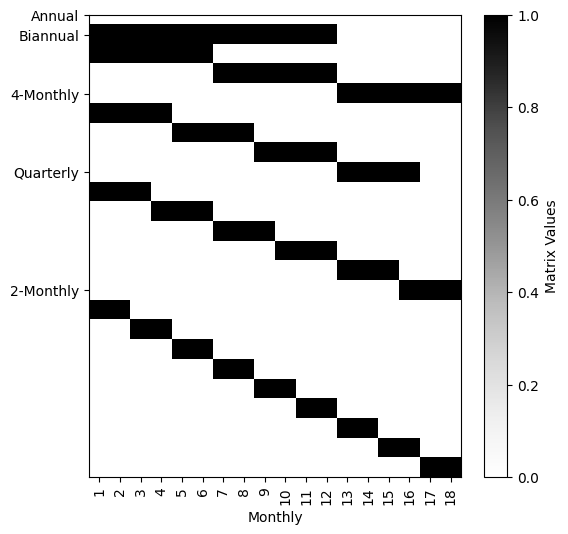

In [23]:
agg_levels = [2, 3, 4, 6, 12]
h = 18

# Generate the reconciliation matrices
rmat = _get_reconc_matrices(agg_levels=agg_levels, h=h)

# Prepare the matrix A for plotting
matrix_A = rmat['A']
# Reverse rows for display to align with R's `apply(t(rmat$A),1,rev)`
matrix_A_transformed = np.flip(matrix_A, axis=0)

# Plot the matrix
plt.figure(figsize=(6, 6))
plt.imshow(matrix_A_transformed, aspect='auto', cmap="Greys", origin="lower")
plt.xlabel(levels[5])
plt.xticks(ticks=np.arange(matrix_A.shape[1]), labels=np.arange(1, matrix_A.shape[1] + 1), rotation=90)
plt.yticks(ticks=[23, 22, 19, 15, 9], labels=levels[:5])
plt.colorbar(label="Matrix Values")

plt.show()


The function `reconc_gaussian` implements the exact Gaussian reconciliation. We also run `reconc_BUIS`, to check the consistency between the two approaches.

In [24]:
base_forecasts_mu = np.array([f["mean"] for f in fc])
base_forecasts_sigma = np.diag([f["sd"] ** 2 for f in fc])  # Variance matrix

# Reconcile Gaussian method
recon_gauss = reconc_gaussian(
    A=rmat['A'],
    base_forecasts_mu=base_forecasts_mu,
    base_forecasts_Sigma=base_forecasts_sigma
)

# Reconcile BUIS method
reconc_buis = reconc_BUIS(
    A=rmat['A'],
    base_forecasts=fc,
    in_type="params",
    distr="gaussian",
    num_samples=20000,
    seed=42
)

# Check consistency of results
bottom_reconciled_mean_gauss = np.dot(rmat['S'], recon_gauss['bottom_reconciled_mean'])
bottom_reconciled_mean_buis = np.mean(reconc_buis['reconciled_samples'], axis=1)

# Round and display results
comparison_results = np.round(np.vstack([
    bottom_reconciled_mean_gauss,
    bottom_reconciled_mean_buis
]))
print(comparison_results)

[[74977. 35913. 39063. 41491. 23520. 25136. 26321. 27174. 17464. 18450.
  19251. 19812. 20412. 21079. 11527. 11993. 12393. 12743. 13047. 13274.
  13531. 13643. 14317.  5694.  5833.  5936.  6056.  6138.  6255.  6324.
   6419.  6508.  6538.  6619.  6655.  6759.  6772.  6881.  6762.  7160.
   7157.]
 [74979. 35900. 39079. 41441. 23512. 25134. 26333. 27129. 17458. 18441.
  19263. 19817. 20419. 21022. 11531. 11981. 12387. 12747. 13052. 13280.
  13519. 13610. 14312.  5701.  5830.  5927.  6054.  6136.  6252.  6322.
   6425.  6516.  6536.  6613.  6667.  6741.  6778.  6900.  6710.  7142.
   7170.]]


The results for the Gaussian reconciliation matches exactly as in R, and the one for BUIS is also similar.

We now compare base forecasts and reconciled forecasts:

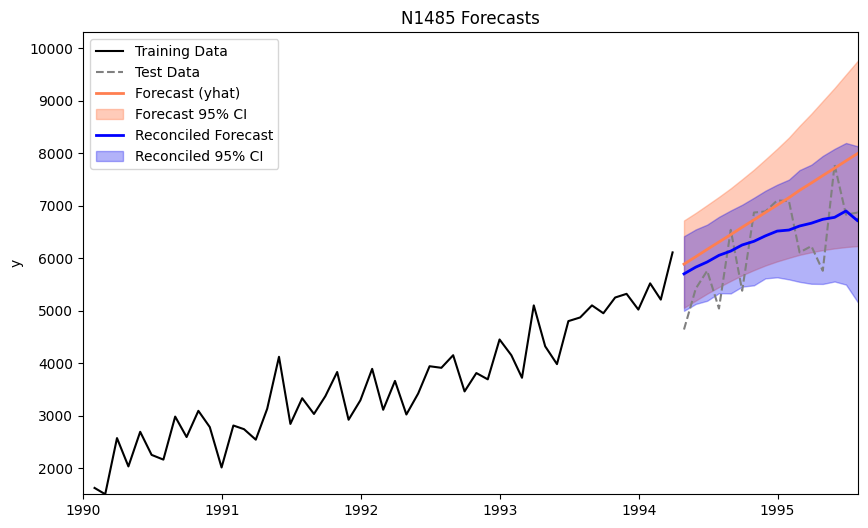

In [25]:
yhat_mu = np.array([f["mean"] for f in fc[-18:]])
yhat_sigma = np.array([f["sd"] for f in fc[-18:]])

# Compute 95% confidence intervals
yhat_hi95 = norm.ppf(0.975, loc=yhat_mu, scale=yhat_sigma)
yhat_lo95 = norm.ppf(0.025, loc=yhat_mu, scale=yhat_sigma)

# Reconciled mean and 95% confidence intervals using quantiles
yreconc_mu = np.mean(reconc_buis['bottom_reconciled_samples'], axis=1)
yreconc_hi95 = np.quantile(reconc_buis['bottom_reconciled_samples'], 0.975, axis=1)
yreconc_lo95 = np.quantile(reconc_buis['bottom_reconciled_samples'], 0.025, axis=1)

# Define the monthly index for the training data (5 years * 12 months)
train_years = pd.date_range(start="1990-01-01", periods=60, freq="ME")

# Define the monthly index for the test data (filter out NaN values)
test_data_flattened = M3_example['test'].values.flatten()
test_data_non_nan = test_data_flattened[~np.isnan(test_data_flattened)]
test_years = pd.date_range(start="1994-04-01", periods=len(test_data_non_nan), freq="ME")

# Determine plot limits
ylim_min = min(M3_example['train'].min().min(), test_data_non_nan.min(), yhat_lo95.min(), yreconc_lo95.min()) - 1
ylim_max = max(M3_example['train'].max().max(), test_data_non_nan.max(), yhat_hi95.max(), yreconc_hi95.max()) + 1

# Plotting
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(train_years, M3_example['train'].values.flatten(), color="black", label="Training Data")

# Plot the test data
plt.plot(test_years, test_data_non_nan, linestyle="--", color="gray", label="Test Data")

# Plot yhat forecasts and confidence interval
plt.plot(test_years, yhat_mu, color="coral", linewidth=2, label="Forecast (yhat)")
plt.fill_between(test_years, yhat_lo95, yhat_hi95, color="#FF7F5066", edgecolor="#FF7F5066", label="Forecast 95% CI")

# Plot reconciled forecasts and confidence interval
plt.plot(test_years, yreconc_mu, color="blue", linewidth=2, label="Reconciled Forecast")
plt.fill_between(test_years, yreconc_lo95, yreconc_hi95, color="#0000EE4D", edgecolor="#0000EE4D", label="Reconciled 95% CI")

# Configure plot
plt.ylim(ylim_min, ylim_max)
plt.xlim(pd.Timestamp("1990-01-01"), pd.Timestamp("1995-08-01"))
plt.ylabel("y")
plt.title("N1485 Forecasts")
plt.legend()
plt.show()

# Gaussian reconciliation of a cross-sectional hierarchy

In this example, we consider the hierarchical time series *infantgts*, which is available from the `hts` package (R. Hyndman et al. 2021) We make it available also in our package as `infantMortality.pkl`.

It contains counts of infant mortality (deaths) in Australia, disaggregated by state and sex (male and female).

The R package obtained base forecast for one year ahead using `auto.arima` from the [`forecast`](https://cran.r-project.org/package=forecast) package. We collect the base forecasts and the residuals from R and make it available as `fc_infantMoratlity.pkl` and `residuals_infantMortality.pkl` respectively, which we will later use to compute the covariance matrix.

In [26]:
infantMortality = pd.read_pickle('../data/infantMortality.pkl')

fc = pd.read_pickle('../data/fc_infantMortality.pkl')
residuals = pd.read_pickle('../data/residuals_infantMortality.pkl')

Now we build the `A` matrix.

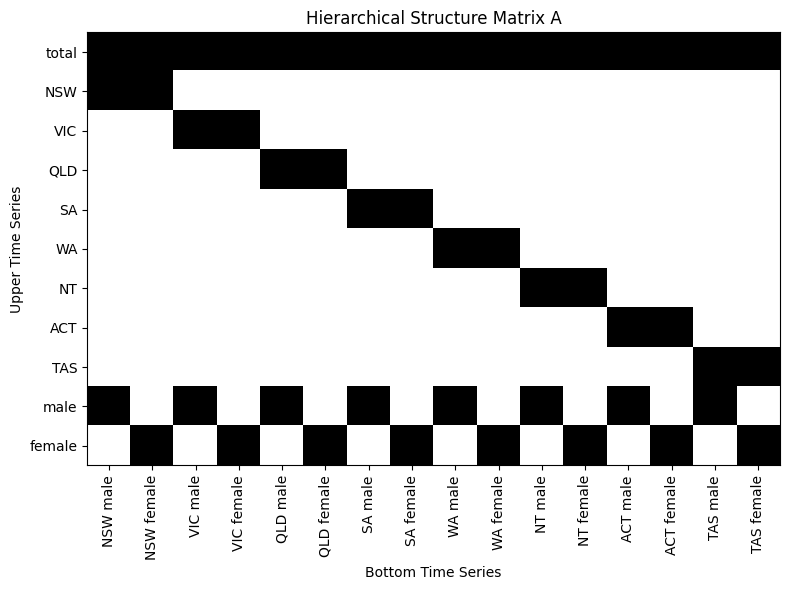

In [27]:
A = np.array([
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
    [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
    [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]
])

# Plotting the matrix A
plt.figure(figsize=(8, 6))
plt.imshow(A, cmap="Greys", aspect="auto")  # Removed np.flipud to avoid inversion

# Setting axis labels
bottom_labels = list(infantMortality.keys())[11:27]  # Adjust as necessary for actual labels
upper_labels = list(infantMortality.keys())[:11]     # Adjust as necessary for actual labels

# Customize ticks
plt.xticks(ticks=np.arange(A.shape[1]), labels=bottom_labels, rotation=90)
plt.yticks(ticks=np.arange(A.shape[0]), labels=upper_labels)  # No reversal for y-axis

# Display the plot
plt.xlabel("Bottom Time Series")
plt.ylabel("Upper Time Series")
plt.title("Hierarchical Structure Matrix A")
plt.tight_layout()
plt.show()

We use `schaferStrimmer_cov` to estimate the covariance matrix of the residuals with shrinkage (Schäfer and Strimmer 2005).

In [28]:
from bayesreconpy.shrink_cov import _schafer_strimmer_cov  # Replace with the actual import path if different

# Means
mu = np.array([fcast[0] for fcast in fc.values()])  # Extracting the means from each forecast entry

# Shrinkage covariance
shrink_res = _schafer_strimmer_cov(residuals)  # Apply shrinkage covariance estimation
lambda_star = shrink_res['lambda_star']
Sigma = shrink_res['shrink_cov']

print(f"The estimated shrinkage intensity is {round(lambda_star, 3)}")

The estimated shrinkage intensity is 0.153


We now perform Gaussian reconciliation:

In [29]:
recon_gauss = reconc_gaussian(A=A, base_forecasts_mu=mu, base_forecasts_Sigma=Sigma)

# Extract reconciled means and covariances
bottom_mu_reconc = recon_gauss['bottom_reconciled_mean']
bottom_Sigma_reconc = recon_gauss['bottom_reconciled_covariance']

# Calculate the reconciled mu and Sigma for the upper variable
upper_mu_reconc = A @ bottom_mu_reconc  # Matrix multiplication
upper_Sigma_reconc = A @ bottom_Sigma_reconc @ A.T

print("Upper reconciled mean:", upper_mu_reconc)

Upper reconciled mean: [688.82409251 190.05372282 165.26902035 173.39775629  40.95861365
  63.82007873  20.37298786  17.24243677  17.70947603 424.30288175
 264.52121076]


The results match exactly as in R.